In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import os

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
csv_path = '/content/drive/MyDrive/Mariposas/Training_set.csv'
train_images_path = '/content/drive/MyDrive/Mariposas/train/'
data_df = pd.read_csv(csv_path)

In [5]:
label_dict = dict(zip(data_df['filename'], data_df['label']))

In [6]:
def load_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize
    return img, label

In [7]:
train_paths = [os.path.join(train_images_path, fname) for fname in data_df['filename']]
train_labels = [label_dict[fname] for fname in data_df['filename']]
class_names = sorted(set(train_labels))
class_indices = {name: i for i, name in enumerate(class_names)}
train_labels_idx = [class_indices[label] for label in train_labels]

In [8]:
filtered_train_paths = [path for path in train_paths if os.path.isfile(path)]
filtered_train_labels_idx = [
    label for path, label in zip(train_paths, train_labels_idx) if os.path.isfile(path)
]

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((filtered_train_paths, filtered_train_labels_idx))
dataset = dataset.map(load_image, num_parallel_calls=AUTOTUNE)

In [10]:
train_size = int(0.8 * len(filtered_train_paths))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [11]:
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal'),
])

In [13]:
num_classes = len(class_names)
img_shape=IMG_SIZE + (3,)

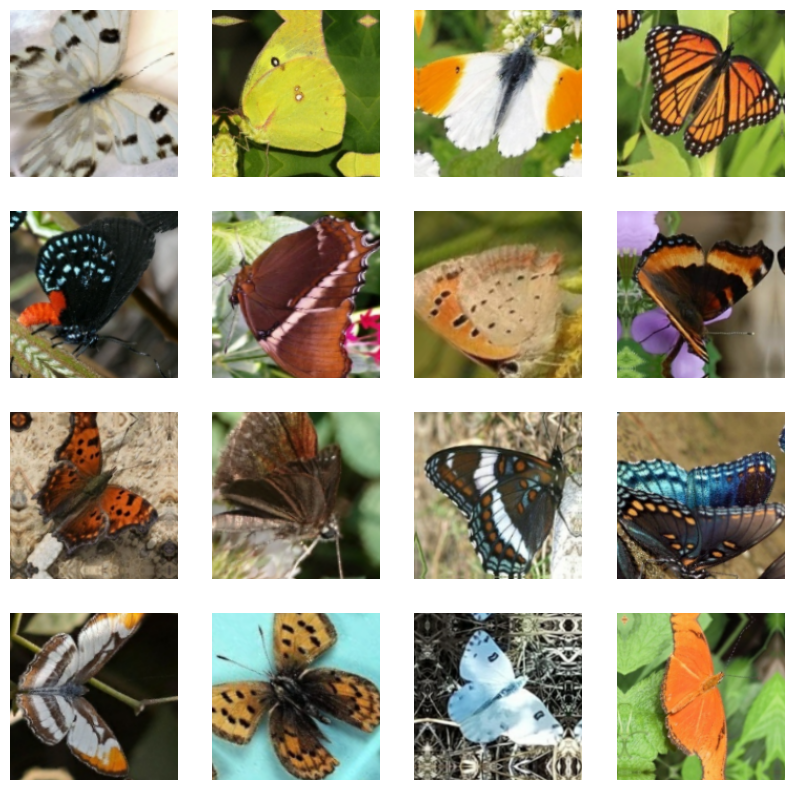

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(16):
        img_augmented = data_augmentation(tf.expand_dims(images[i], axis=0))
        img_augmented = tf.clip_by_value(img_augmented * 255, 0, 255)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(img_augmented[0].numpy().astype('uint8'))
        plt.axis('off')
plt.show()

In [ ]:

model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(64, 3, strides=2, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, strides=2, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=50)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 216ms/step - accuracy: 0.0147 - loss: 4.3177 - val_accuracy: 0.0185 - val_loss: 4.3178
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.0200 - loss: 4.3162 - val_accuracy: 0.0185 - val_loss: 4.3182
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.0231 - loss: 4.3137 - val_accuracy: 0.0185 - val_loss: 4.3191
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.0209 - loss: 4.3132 - val_accuracy: 0.0185 - val_loss: 4.3209
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.0228 - loss: 4.3115 - val_accuracy: 0.0185 - val_loss: 4.3208
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.0226 - loss: 4.3111 - val_accuracy: 0.0185 - val_loss: 4.3218
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.0217 - loss: 4.3106 - val_accuracy: 0.0185 - val_loss: 4.3227
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.0216 - loss: 4

In [ ]:
model.evaluate(val_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.1580 - loss: 3.2776


[3.2496166229248047, 0.16230769455432892]

In [ ]:
predicciones=model.predict(val_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step


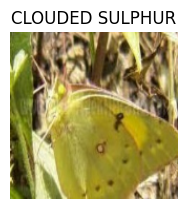

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Esta imágen es mas probable a pertenecer a GREY HAIRSTREAK con a 5.763905 porcentaje de confianza


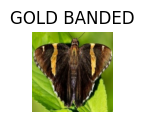

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Esta imágen es mas probable a pertenecer a RED ADMIRAL con a 8.558209 porcentaje de confianza


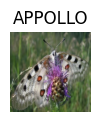

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Esta imágen es mas probable a pertenecer a SLEEPY ORANGE con a 6.864010 porcentaje de confianza


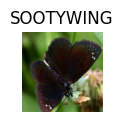

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Esta imágen es mas probable a pertenecer a POPINJAY con a 24.828968 porcentaje de confianza


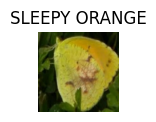

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Esta imágen es mas probable a pertenecer a SLEEPY ORANGE con a 13.146398 porcentaje de confianza


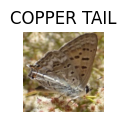

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Esta imágen es mas probable a pertenecer a EASTERN PINE ELFIN con a 8.951282 porcentaje de confianza


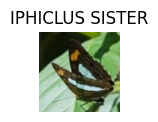

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Esta imágen es mas probable a pertenecer a GREAT JAY con a 9.733311 porcentaje de confianza


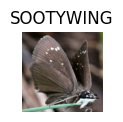

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Esta imágen es mas probable a pertenecer a PIPEVINE SWALLOW con a 3.917361 porcentaje de confianza


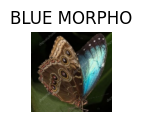

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Esta imágen es mas probable a pertenecer a TWO BARRED FLASHER con a 7.281867 porcentaje de confianza


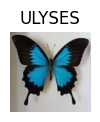

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Esta imágen es mas probable a pertenecer a GREAT JAY con a 8.581322 porcentaje de confianza


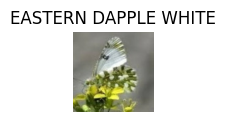

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Esta imágen es mas probable a pertenecer a SCARCE SWALLOW con a 16.630230 porcentaje de confianza


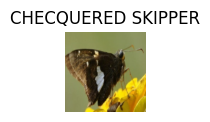

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Esta imágen es mas probable a pertenecer a SILVER SPOT SKIPPER con a 10.183053 porcentaje de confianza


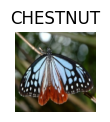

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Esta imágen es mas probable a pertenecer a ELBOWED PIERROT con a 10.852165 porcentaje de confianza


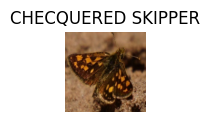

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Esta imágen es mas probable a pertenecer a ATALA con a 9.386356 porcentaje de confianza


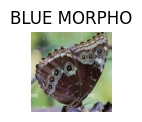

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Esta imágen es mas probable a pertenecer a ATALA con a 11.075028 porcentaje de confianza


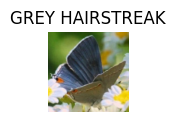

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Esta imágen es mas probable a pertenecer a RED SPOTTED PURPLE con a 5.994528 porcentaje de confianza


In [ ]:
plt.figure(figsize=(10,10))
for images, labels in val_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        img_display = images[i].numpy() * 255
        plt.imshow(img_display.astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        plt.show()

        img_array=keras.preprocessing.image.img_to_array(images[i])  #Las imagenes conviertalas en arreglos
        img_array=tf.expand_dims(img_array,0)  #Va a empezara  recorrer desde el punto 0
        predictions=model.predict(img_array)
        score=tf.nn.softmax(predictions[0])

        print('Esta imágen es mas probable a pertenecer a {} con a {:2f} porcentaje de confianza'.format(class_names[tf.argmax(score)],100*tf.reduce_max(score)))


#Arquitectura Inception

In [ ]:
inception=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=img_shape)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
model2=keras.Sequential([
    inception,
    Flatten(),
    Dense(100,activation='relu'),
    keras.layers.Dropout(0.2),
    Dense(num_classes)
])

In [ ]:
model2.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model2.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2061s 13s/step - accuracy: 0.0515 - loss: 4.1472 - val_accuracy: 0.0177 - val_loss: 4.4281
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 395ms/step - accuracy: 0.1652 - loss: 3.3745 - val_accuracy: 0.2292 - val_loss: 3.1227
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 278ms/step - accuracy: 0.3057 - loss: 2.5698 - val_accuracy: 0.2000 - val_loss: 3.3065
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 401ms/step - accuracy: 0.3500 - loss: 2.3302 - val_accuracy: 0.4023 - val_loss: 2.3355
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 272ms/step - accuracy: 0.4191 - loss: 2.0891 - val_accuracy: 0.0646 - val_loss: 8.1633
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 396ms/step - accuracy: 0.3612 - loss: 2.3565 - val_accuracy: 0.0138 - val_loss: 5.0799
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 278ms/step - accuracy: 0.4039 - loss: 2.1030 - val_accuracy: 0.5862 - val_loss: 1.4292
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 394ms/step - accuracy: 0.5298 - loss

In [ ]:
model2.evaluate(val_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.4233 - loss: 2.3779


[2.360330820083618, 0.41999998688697815]

In [ ]:
predicciones=model2.predict(val_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step


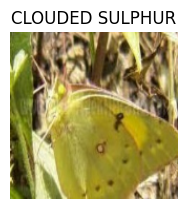

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Esta imágen es mas probable a pertenecer a CLOUDED SULPHUR con a 32.086258 porcentaje de confianza


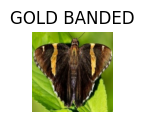

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Esta imágen es mas probable a pertenecer a MILBERTS TORTOISESHELL con a 71.462219 porcentaje de confianza


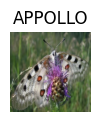

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Esta imágen es mas probable a pertenecer a APPOLLO con a 88.927841 porcentaje de confianza


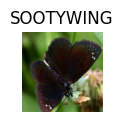

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Esta imágen es mas probable a pertenecer a COMMON BANDED AWL con a 21.600336 porcentaje de confianza


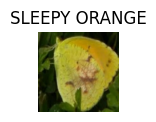

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Esta imágen es mas probable a pertenecer a SLEEPY ORANGE con a 47.938457 porcentaje de confianza


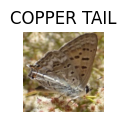

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Esta imágen es mas probable a pertenecer a COPPER TAIL con a 87.463181 porcentaje de confianza


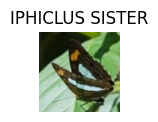

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Esta imágen es mas probable a pertenecer a ZEBRA LONG WING con a 54.592438 porcentaje de confianza


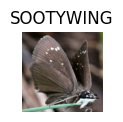

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Esta imágen es mas probable a pertenecer a BLUE MORPHO con a 41.346939 porcentaje de confianza


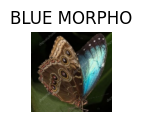

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Esta imágen es mas probable a pertenecer a WOOD SATYR con a 50.996346 porcentaje de confianza


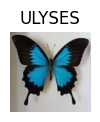

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Esta imágen es mas probable a pertenecer a ULYSES con a 1.544490 porcentaje de confianza


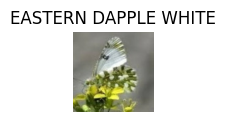

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Esta imágen es mas probable a pertenecer a EASTERN DAPPLE WHITE con a 47.773411 porcentaje de confianza


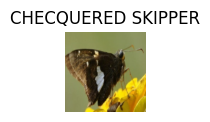

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Esta imágen es mas probable a pertenecer a SILVER SPOT SKIPPER con a 66.899559 porcentaje de confianza


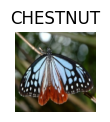

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Esta imágen es mas probable a pertenecer a MONARCH con a 59.923084 porcentaje de confianza


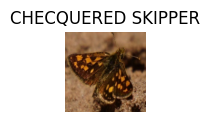

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Esta imágen es mas probable a pertenecer a PAINTED LADY con a 62.362244 porcentaje de confianza


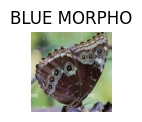

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Esta imágen es mas probable a pertenecer a BLUE MORPHO con a 80.478508 porcentaje de confianza


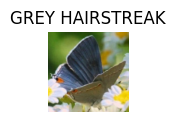

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Esta imágen es mas probable a pertenecer a GREY HAIRSTREAK con a 37.917744 porcentaje de confianza


In [ ]:
plt.figure(figsize=(10,10))
for images, labels in val_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        img_display = images[i].numpy() * 255
        plt.imshow(img_display.astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        plt.show()

        img_array=keras.preprocessing.image.img_to_array(images[i])  #Las imagenes conviertalas en arreglos
        img_array=tf.expand_dims(img_array,0)  #Va a empezara  recorrer desde el punto 0
        predictions=model2.predict(img_array)
        score=tf.nn.softmax(predictions[0])

        print('Esta imágen es mas probable a pertenecer a {} con a {:2f} porcentaje de confianza'.format(class_names[tf.argmax(score)],100*tf.reduce_max(score)))


## Arquitectura Eficient net

In [ ]:
arq_eff_b3=tf.keras.applications.EfficientNetB3(include_top=False,weights='imagenet',input_shape=img_shape)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model3=keras.Sequential([
    arq_eff_b3,
    Flatten(),
    Dense(100,activation='relu'),
    keras.layers.Dropout(0.2),
    Dense(num_classes)
])

In [ ]:
model3.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model3.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1664s 10s/step - accuracy: 0.5578 - loss: 1.8504 - val_accuracy: 0.0192 - val_loss: 6.3083
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 265ms/step - accuracy: 0.7189 - loss: 1.1795 - val_accuracy: 0.0192 - val_loss: 5.8297
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 265ms/step - accuracy: 0.7737 - loss: 0.8695 - val_accuracy: 0.2700 - val_loss: 4.4369
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - accuracy: 0.8212 - loss: 0.7638 - val_accuracy: 0.5115 - val_loss: 3.5345
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 283ms/step - accuracy: 0.8297 - loss: 0.6930 - val_accuracy: 0.6908 - val_loss: 1.8493
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 259ms/step - accuracy: 0.8327 - loss: 0.6508 - val_accuracy: 0.8054 - val_loss: 1.1819
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 278ms/step - accuracy: 0.8645 - loss: 0.5545 - val_accuracy: 0.7677 - val_loss: 1.5623
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 279ms/step - accuracy: 0.8782 - loss: 0

In [ ]:
model3.evaluate(val_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.7936 - loss: 1.3452


[1.317577838897705, 0.8030769228935242]

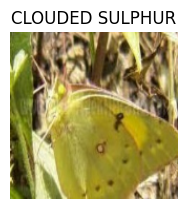

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Esta imágen es mas probable a pertenecer a CLOUDED SULPHUR con a 52.105911 porcentaje de confianza


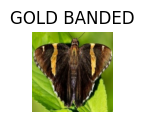

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Esta imágen es mas probable a pertenecer a GOLD BANDED con a 99.997124 porcentaje de confianza


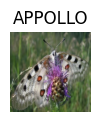

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Esta imágen es mas probable a pertenecer a APPOLLO con a 99.991798 porcentaje de confianza


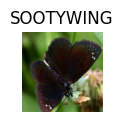

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Esta imágen es mas probable a pertenecer a COMMON BANDED AWL con a 88.762566 porcentaje de confianza


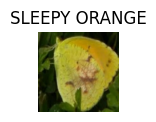

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Esta imágen es mas probable a pertenecer a SLEEPY ORANGE con a 99.945297 porcentaje de confianza


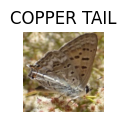

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Esta imágen es mas probable a pertenecer a COPPER TAIL con a 99.982292 porcentaje de confianza


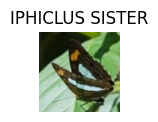

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Esta imágen es mas probable a pertenecer a IPHICLUS SISTER con a 99.682861 porcentaje de confianza


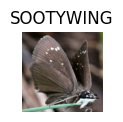

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Esta imágen es mas probable a pertenecer a COMMON WOOD-NYMPH con a 58.528431 porcentaje de confianza


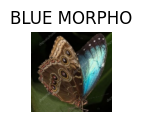

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Esta imágen es mas probable a pertenecer a BLUE MORPHO con a 99.554787 porcentaje de confianza


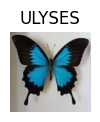

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Esta imágen es mas probable a pertenecer a ULYSES con a 100.000000 porcentaje de confianza


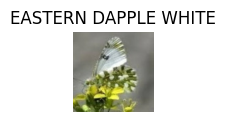

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Esta imágen es mas probable a pertenecer a EASTERN DAPPLE WHITE con a 99.811684 porcentaje de confianza


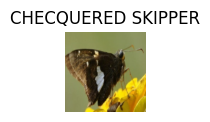

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Esta imágen es mas probable a pertenecer a SILVER SPOT SKIPPER con a 99.999977 porcentaje de confianza


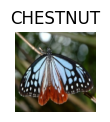

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Esta imágen es mas probable a pertenecer a CHESTNUT con a 100.000000 porcentaje de confianza


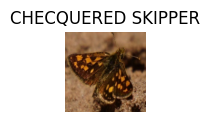

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Esta imágen es mas probable a pertenecer a CHECQUERED SKIPPER con a 100.000000 porcentaje de confianza


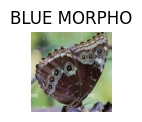

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Esta imágen es mas probable a pertenecer a BLUE MORPHO con a 99.999916 porcentaje de confianza


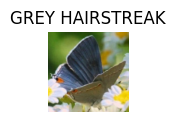

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Esta imágen es mas probable a pertenecer a GREY HAIRSTREAK con a 99.998871 porcentaje de confianza


In [ ]:
plt.figure(figsize=(10,10))
for images, labels in val_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        img_display = images[i].numpy() * 255
        plt.imshow(img_display.astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        plt.show()

        img_array=keras.preprocessing.image.img_to_array(images[i])  #Las imagenes conviertalas en arreglos
        img_array=tf.expand_dims(img_array,0)  #Va a empezara  recorrer desde el punto 0
        predictions=model3.predict(img_array)
        score=tf.nn.softmax(predictions[0])

        print('Esta imágen es mas probable a pertenecer a {} con a {:2f} porcentaje de confianza'.format(class_names[tf.argmax(score)],100*tf.reduce_max(score)))


## Arquitectura Xception

In [ ]:
xception=tf.keras.applications.Xception(include_top=False,weights='imagenet',input_shape=img_shape)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model4=keras.Sequential([
    xception,
    Dense(100,activation='relu'),
    Flatten(),
    keras.layers.Dropout(0.2),
    Dense(num_classes)
])

In [ ]:
model4.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model4.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2932s 16s/step - accuracy: 0.2509 - loss: 3.2845 - val_accuracy: 0.4977 - val_loss: 2.9630
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2453s 15s/step - accuracy: 0.7294 - loss: 0.9821 - val_accuracy: 0.7538 - val_loss: 1.0300
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2439s 15s/step - accuracy: 0.8213 - loss: 0.6251 - val_accuracy: 0.7708 - val_loss: 0.9109
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2462s 15s/step - accuracy: 0.8764 - loss: 0.4108 - val_accuracy: 0.7815 - val_loss: 0.9754
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2403s 15s/step - accuracy: 0.8925 - loss: 0.3733 - val_accuracy: 0.7992 - val_loss: 0.9351
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2428s 15s/step - accuracy: 0.8988 - loss: 0.3324 - val_accuracy: 0.7762 - val_loss: 1.1041
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2422s 15s/step - accuracy: 0.9083 - loss: 0.3242 - val_accuracy: 0.6492 - val_loss: 1.6340
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2423s 15s/step - accuracy: 0.9391 - loss: 0

In [ ]:
model4.evaluate(val_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.7733 - loss: 1.3747


[1.348280668258667, 0.7638461589813232]

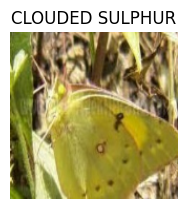

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Esta imágen es mas probable a pertenecer a SOUTHERN DOGFACE con a 51.113159 porcentaje de confianza


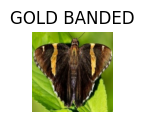

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Esta imágen es mas probable a pertenecer a GOLD BANDED con a 99.998978 porcentaje de confianza


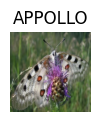

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Esta imágen es mas probable a pertenecer a APPOLLO con a 99.999794 porcentaje de confianza


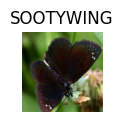

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Esta imágen es mas probable a pertenecer a SOOTYWING con a 92.170151 porcentaje de confianza


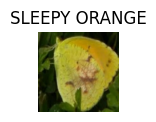

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Esta imágen es mas probable a pertenecer a SLEEPY ORANGE con a 99.967155 porcentaje de confianza


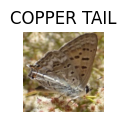

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Esta imágen es mas probable a pertenecer a COPPER TAIL con a 99.434677 porcentaje de confianza


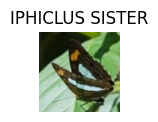

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Esta imágen es mas probable a pertenecer a IPHICLUS SISTER con a 99.504616 porcentaje de confianza


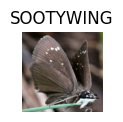

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Esta imágen es mas probable a pertenecer a SOOTYWING con a 94.558372 porcentaje de confianza


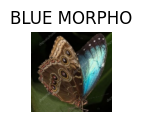

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Esta imágen es mas probable a pertenecer a BLUE MORPHO con a 99.999702 porcentaje de confianza


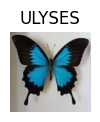

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Esta imágen es mas probable a pertenecer a ULYSES con a 99.999985 porcentaje de confianza


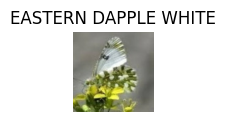

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Esta imágen es mas probable a pertenecer a EASTERN DAPPLE WHITE con a 42.097733 porcentaje de confianza


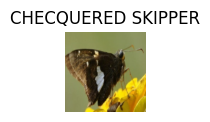

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Esta imágen es mas probable a pertenecer a SILVER SPOT SKIPPER con a 99.795380 porcentaje de confianza


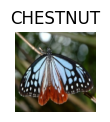

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Esta imágen es mas probable a pertenecer a CHESTNUT con a 99.997818 porcentaje de confianza


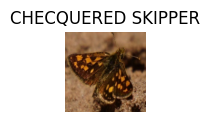

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Esta imágen es mas probable a pertenecer a CHECQUERED SKIPPER con a 100.000000 porcentaje de confianza


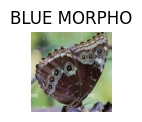

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Esta imágen es mas probable a pertenecer a BLUE MORPHO con a 99.995148 porcentaje de confianza


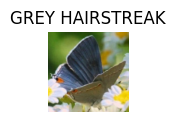

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Esta imágen es mas probable a pertenecer a GREY HAIRSTREAK con a 89.025177 porcentaje de confianza


In [ ]:
plt.figure(figsize=(10,10))
for images, labels in val_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        img_display = images[i].numpy() * 255
        plt.imshow(img_display.astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        plt.show()

        img_array=keras.preprocessing.image.img_to_array(images[i])  #Las imagenes conviertalas en arreglos
        img_array=tf.expand_dims(img_array,0)  #Va a empezara  recorrer desde el punto 0
        predictions=model4.predict(img_array)
        score=tf.nn.softmax(predictions[0])

        print('Esta imágen es mas probable a pertenecer a {} con a {:2f} porcentaje de confianza'.format(class_names[tf.argmax(score)],100*tf.reduce_max(score)))


## Arquitectura Nas-Net

In [14]:
nasnet=tf.keras.applications.NASNetLarge(include_top=False,weights='imagenet',input_shape=img_shape)

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
model5=keras.Sequential([
    nasnet,
    Dense(100,activation='relu'),
    Flatten(),
    keras.layers.Dropout(0.2),
    Dense(num_classes)
])

In [16]:
model5.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [18]:
model5.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1568s 7s/step - accuracy: 0.1278 - loss: 3.8986 - val_accuracy: 0.0162 - val_loss: 815.4119
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 839ms/step - accuracy: 0.4134 - loss: 2.1377 - val_accuracy: 0.0215 - val_loss: 36385.6328
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 160s 966ms/step - accuracy: 0.6126 - loss: 1.3339 - val_accuracy: 0.0138 - val_loss: 4582.4565
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 841ms/step - accuracy: 0.7291 - loss: 0.8981 - val_accuracy: 0.0108 - val_loss: 59250.0781
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 972ms/step - accuracy: 0.8033 - loss: 0.6651 - val_accuracy: 0.0177 - val_loss: 19098.0820
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 976ms/step - accuracy: 0.8393 - loss: 0.5163 - val_accuracy: 0.0192 - val_loss: 8820.8564
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 835ms/step - accuracy: 0.8697 - loss: 0.4395 - val_accuracy: 0.0154 - val_loss: 763.3633
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 842ms/step 

In [19]:
model5.evaluate(val_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.0167 - loss: 12524.5264


[12452.0888671875, 0.011538461782038212]

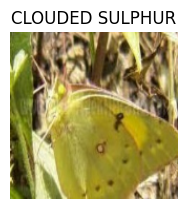

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


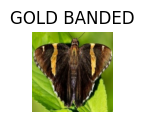

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


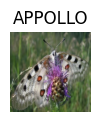

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


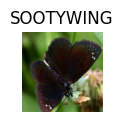

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


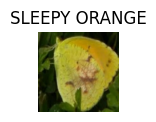

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


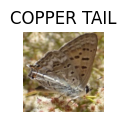

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


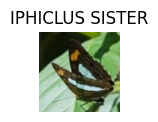

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


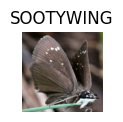

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


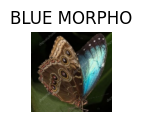

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


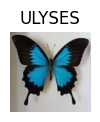

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


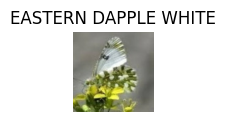

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


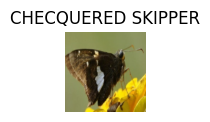

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


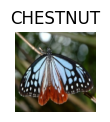

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


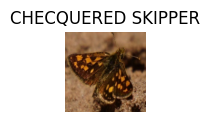

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


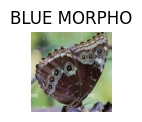

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


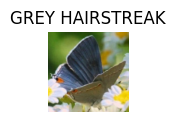

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Esta imágen es mas probable a pertenecer a STRAITED QUEEN con a 100.000000 porcentaje de confianza


In [20]:
plt.figure(figsize=(10,10))
for images, labels in val_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        img_display = images[i].numpy() * 255
        plt.imshow(img_display.astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        plt.show()

        img_array=keras.preprocessing.image.img_to_array(images[i])  #Las imagenes conviertalas en arreglos
        img_array=tf.expand_dims(img_array,0)  #Va a empezara  recorrer desde el punto 0
        predictions=model5.predict(img_array)
        score=tf.nn.softmax(predictions[0])

        print('Esta imágen es mas probable a pertenecer a {} con a {:2f} porcentaje de confianza'.format(class_names[tf.argmax(score)],100*tf.reduce_max(score)))


## Arquitectura Mobilenet

In [ ]:
mobile=tf.keras.applications.MobileNet(include_top=False,weights='imagenet',input_shape=img_shape)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model6=keras.Sequential([
    mobile,
    Dense(100,activation='relu'),
    Flatten(),
    keras.layers.Dropout(0.2),
    Dense(num_classes)
])

In [ ]:
model6.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model6.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 600s 4s/step - accuracy: 0.8276 - loss: 0.5724 - val_accuracy: 0.7131 - val_loss: 1.0903
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 582s 4s/step - accuracy: 0.8696 - loss: 0.4417 - val_accuracy: 0.5908 - val_loss: 1.9157
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 627s 4s/step - accuracy: 0.8849 - loss: 0.3792 - val_accuracy: 0.6931 - val_loss: 1.3592
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 620s 4s/step - accuracy: 0.9093 - loss: 0.3013 - val_accuracy: 0.6938 - val_loss: 1.5417
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 614s 4s/step - accuracy: 0.9192 - loss: 0.2798 - val_accuracy: 0.7192 - val_loss: 1.3760
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 620s 4s/step - accuracy: 0.9177 - loss: 0.2664 - val_accuracy: 0.7800 - val_loss: 1.1218
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 599s 4s/step - accuracy: 0.9155 - loss: 0.3016 - val_accuracy: 0.7277 - val_loss: 1.4088
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 634s 4s/step - accuracy: 0.9259 - loss: 0.2270 - val_accu

In [ ]:
model6.evaluate(val_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 748ms/step - accuracy: 0.7954 - loss: 1.0784


[1.0547863245010376, 0.7923076748847961]

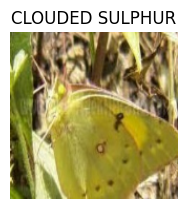

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Esta imágen es mas probable a pertenecer a CLOUDED SULPHUR con a 67.335060 porcentaje de confianza


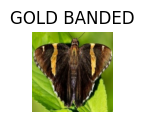

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Esta imágen es mas probable a pertenecer a GOLD BANDED con a 99.964294 porcentaje de confianza


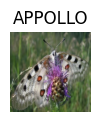

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Esta imágen es mas probable a pertenecer a APPOLLO con a 98.869728 porcentaje de confianza


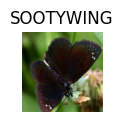

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Esta imágen es mas probable a pertenecer a SOOTYWING con a 95.956383 porcentaje de confianza


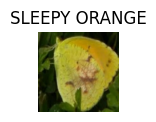

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Esta imágen es mas probable a pertenecer a SLEEPY ORANGE con a 84.337273 porcentaje de confianza


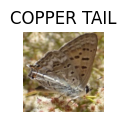

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Esta imágen es mas probable a pertenecer a COPPER TAIL con a 59.331577 porcentaje de confianza


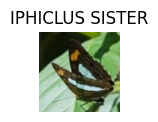

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Esta imágen es mas probable a pertenecer a IPHICLUS SISTER con a 67.754967 porcentaje de confianza


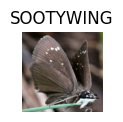

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Esta imágen es mas probable a pertenecer a BLACK HAIRSTREAK con a 99.088791 porcentaje de confianza


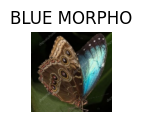

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Esta imágen es mas probable a pertenecer a BLUE MORPHO con a 98.651070 porcentaje de confianza


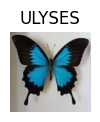

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Esta imágen es mas probable a pertenecer a ULYSES con a 99.999855 porcentaje de confianza


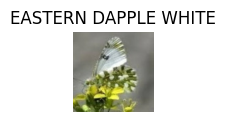

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Esta imágen es mas probable a pertenecer a LARGE MARBLE con a 98.585823 porcentaje de confianza


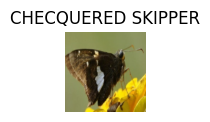

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Esta imágen es mas probable a pertenecer a SILVER SPOT SKIPPER con a 98.091492 porcentaje de confianza


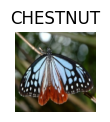

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Esta imágen es mas probable a pertenecer a CHESTNUT con a 99.995995 porcentaje de confianza


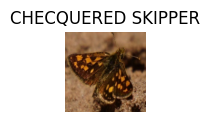

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Esta imágen es mas probable a pertenecer a CHECQUERED SKIPPER con a 99.941277 porcentaje de confianza


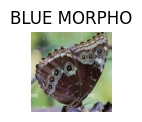

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Esta imágen es mas probable a pertenecer a BLUE MORPHO con a 99.767570 porcentaje de confianza


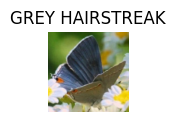

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Esta imágen es mas probable a pertenecer a GREY HAIRSTREAK con a 84.544365 porcentaje de confianza


In [ ]:
plt.figure(figsize=(10,10))
for images, labels in val_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        img_display = images[i].numpy() * 255
        plt.imshow(img_display.astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        plt.show()

        img_array=keras.preprocessing.image.img_to_array(images[i])  #Las imagenes conviertalas en arreglos
        img_array=tf.expand_dims(img_array,0)  #Va a empezara  recorrer desde el punto 0
        predictions=model6.predict(img_array)
        score=tf.nn.softmax(predictions[0])

        print('Esta imágen es mas probable a pertenecer a {} con a {:2f} porcentaje de confianza'.format(class_names[tf.argmax(score)],100*tf.reduce_max(score)))


In [ ]:
test_images_path = '/content/drive/MyDrive/Mariposas/train/'
test_csv_path = '/content/drive/MyDrive/Mariposas/Testing_set.csv'
output_csv_path = '/content/drive/MyDrive/Mariposas/output_predictions.csv'

In [ ]:
test_df = pd.read_csv(test_csv_path)

In [ ]:
predictions = []

In [ ]:
for img_name in test_df['filename']:
    img_path = os.path.join(test_images_path, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(160, 160))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions_array = model6.predict(img_array)
    score = tf.nn.softmax(predictions_array[0])
    predicted_class = class_names[tf.argmax(score)]
    predictions.append([img_name, predicted_class])

In [ ]:
output_df = pd.DataFrame(predictions, columns=['filename', 'predicted_class'])
output_df.to_csv(output_csv_path, index=False)